### Imports

In [1]:
# Import necessary libraries
import warnings
import math
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt 
import seaborn as sns 
from preprocessing import get_missing_values_columns, preprocessing

### Ignoring warnings

In [2]:
# Suppress all warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [3]:
# Setting dataset folder path
FOLDER_PATH = "../data/"

# Load training data (transactions)
train_df = pd.read_csv(f'{FOLDER_PATH}/train.csv')       

# Load customer data
customer_df = pd.read_csv(f'{FOLDER_PATH}/customer.csv') 

# Load terminal (merchant) data
terminal_df = pd.read_csv(f'{FOLDER_PATH}/terminal.csv') 

# Merging the dataset
train_df = pd.merge(train_df, customer_df, on='CUSTOMER_ID', how='left')  
train = pd.merge(train_df, terminal_df, on='TERMINAL_ID', how='left')  

### Applying Pre-processing (Handling null values, remove duplicates and fixing datatypes)

In [4]:
# Checking for null values
print("Columns with missing value : ", get_missing_values_columns(train))

Columns with missing value :  TX_AMOUNT    7
dtype: int64


In [5]:
train = preprocessing(train)

# Checking for null values after preprocessing
print("Columns with missing value : ", get_missing_values_columns(train))

Columns with missing value :  Series([], dtype: int64)


### Feature Engineering

#### 1. Extracting time-based features

In [6]:
# Extracting hour, day, month and weekday from tx_datetime column
train['TX_HOUR'] = train['TX_DATETIME'].dt.hour
train['TX_DAY'] = train['TX_DATETIME'].dt.day
train['TX_MONTH'] = train['TX_DATETIME'].dt.month
train['TX_WEEKDAY'] = train['TX_DATETIME'].dt.weekday

#### 2. Customer behaviour features

In [7]:
# Customer Fraud History (Has customer been involved in fraud before?)
customer_fraud_history = train.groupby('CUSTOMER_ID')['TX_FRAUD'].max()
train = train.merge(customer_fraud_history.rename('CUSTOMER_FRAUD_HISTORY'), on='CUSTOMER_ID', how='left')


#### 3. Terminal based features

In [8]:
# Feature Engineering: Creating new feature for transaction frequency per terminal
train['tx_per_terminal'] = train.groupby('TERMINAL_ID')['TRANSACTION_ID'].transform('count')

# Terminal Fraud Rate (Proportion of fraudulent transactions at each terminal)
terminal_fraud_rate = train.groupby('TERMINAL_ID')['TX_FRAUD'].mean()
train = train.merge(terminal_fraud_rate.rename('TERMINAL_FRAUD_RATE'), on='TERMINAL_ID', how='left')

# Determine whether the transaction occurred at a terminal that is included in the customer's list of available terminals.
train['isAllowedTerminal'] = train.apply(lambda row: int(row['TERMINAL_ID'] in row['available_terminals']), axis=1)

#### 4. Transaction based features

In [9]:

# Transaction Amount Compared to Terminal's Typical Amount (Relative to Terminal's Average)
terminal_avg_tx = train.groupby('TERMINAL_ID')['TX_AMOUNT'].mean()
train = train.merge(terminal_avg_tx.rename('TERMINAL_AVG_TX_AMOUNT'), on='TERMINAL_ID', how='left')
train['TX_AMOUNT_REL_TO_TERMINAL_AVG'] = train['TX_AMOUNT'] / train['TERMINAL_AVG_TX_AMOUNT']

#### 5. Geographical features

In [10]:
# Finding the distance(km) between the customers home and the terminal at which the transaction took place.

# Define the Haversine function to calculate distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance

# Apply the Haversine function row-wise
train['Distance_km'] = train.apply(lambda row: haversine(row['x_customer_id'], row['y_customer_id'], row['x_terminal_id'], row['y_terminal_id']), axis=1).round()

In [11]:
# List of columns in train dataset after feature engineering
train.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id',
       'mean_amount', 'std_amount', 'mean_nb_tx_per_day',
       'available_terminals', 'nb_terminals', 'x_terminal_id', 'y_terminal_id',
       'TX_HOUR', 'TX_DAY', 'TX_MONTH', 'TX_WEEKDAY', 'CUSTOMER_FRAUD_HISTORY',
       'tx_per_terminal', 'TERMINAL_FRAUD_RATE', 'isAllowedTerminal',
       'TERMINAL_AVG_TX_AMOUNT', 'TX_AMOUNT_REL_TO_TERMINAL_AVG',
       'Distance_km'],
      dtype='object')

# Feature selection

In [12]:
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'x_customer_id', 'y_customer_id', 'x_terminal_id', 'y_terminal_id',
       'TX_AMOUNT','mean_amount', 'std_amount', 'mean_nb_tx_per_day',
       'TX_HOUR', 'TX_DAY', 'TX_MONTH', 'TX_WEEKDAY', 'CUSTOMER_FRAUD_HISTORY', 'tx_per_terminal', 'TERMINAL_FRAUD_RATE',
       'isAllowedTerminal', 'TERMINAL_AVG_TX_AMOUNT',
       'TX_AMOUNT_REL_TO_TERMINAL_AVG', 'Distance_km']

X = train[features]
y = train['TX_FRAUD']

# Spliting the dataset

In [13]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying Sampling as the dataset has only 2.26% fraud transactions, making it a minority

In [14]:
# Apply SMOTEENN (Combination of SMOTE and ENN) to balance the dataset
# SMOTE oversamples the minority class(which is 'TX_FRAUD' == 1), and ENN (Edited Nearest Neighbors) undersamples the majority class(which is 'TX_FRAUD' == 0)
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

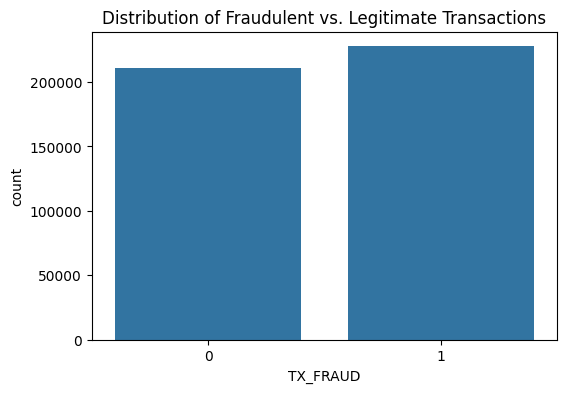

Percentage of fraudulent after sampling transactions: 51.91%


In [15]:
y_resampled_df = pd.DataFrame(y_resampled, columns=['TX_FRAUD'])

# Check the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='TX_FRAUD', data=y_resampled_df[['TX_FRAUD']])
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.show()

# Display the percentage of fraudulent transactions
fraud_percentage = round(y_resampled_df['TX_FRAUD'].mean() * 100,2)
print(f"Percentage of fraudulent after sampling transactions: {fraud_percentage}%")

# Finding best estimaters for XGBClassifier model using RandomizedSearchCV

In [16]:
file_path = '../hyperparameters/xgb_estimaters.json'

# If hyperparameters already generated, then we won't generate it again
if not os.path.exists(file_path):
    print("file not exist ", file_path)
    print("Generating file...")

    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [0.8, 1.0, 1.2]
        }
    
    # Set up RandomizedSearchCV with 50 iterations
    Model = RandomizedSearchCV(estimator= XGBClassifier(random_state = 42), param_distributions= param_dist, 
                                  n_iter=50, cv=3, n_jobs=-1, scoring='precision', random_state=42)
    
    # Fit the model using RandomizedSearchCV
    Model.fit(X_resampled, y_resampled)

    # Print the best parameters and the best score
    print("Best parameters found: ", Model.best_estimator_)
    print("Best cross-validation score: ", Model.best_score_)
    print("Saving estimaters at: ", file_path)
    
    estimaters = Model.best_estimator_.get_params()
    # Writing dictionary to a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(estimaters, json_file, indent=4)  # 'indent' makes the JSON file readable

else:
    print("file exist")
    # Reading the JSON file as a dictionary
    with open(file_path, 'r') as json_file:
        estimaters = json.load(json_file)
    print("Best parameters found: ", estimaters)

file exist
Best parameters found:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1.2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


# Training the Model

In [17]:
# Initialize the model
xgb_model = XGBClassifier(**estimaters) 
    
# Fit the model
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Make predictions

In [18]:

y_pred = xgb_model.predict(X_test_scaled)

# Display the evaluation results
print(f"Accuracy:- {round(accuracy_score(y_test, y_pred)*100,2)}%")
print(f"Precision:- {round(precision_score(y_test, y_pred, average='macro', zero_division=0)*100,2)}%")
print(f"Recall:- {round(recall_score(y_test, y_pred, average='macro', zero_division=0)*100,2)}%")
print(f"Classification report:- {classification_report(y_test, y_pred)}")

Accuracy:- 98.06%
Precision:- 76.66%
Recall:- 88.15%
Classification report:-               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56977
           1       0.54      0.78      0.64      1270

    accuracy                           0.98     58247
   macro avg       0.77      0.88      0.81     58247
weighted avg       0.99      0.98      0.98     58247

